In [264]:
import pickle
import torch
import sys
import gym
from gym import ObservationWrapper
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

sys.path.append('..')


class TorchWrapper(ObservationWrapper):
    def observation(self, obs):
        return torch.tensor(obs).float()

agts = pickle.load(open('../agts.pickle', 'rb'))
envs = [
    TorchWrapper(gym.make('CartPole-v1')),
    TorchWrapper(gym.make('Acrobot-v1')),
    TorchWrapper(gym.make('MountainCar-v0'))
]

cartpole_states = torch.zeros((1000, envs[0].observation_space.shape[0]))
acrobot_states = torch.zeros((1000, envs[1].observation_space.shape[0]))
mountaincar_states = torch.zeros((1000, envs[2].observation_space.shape[0]))
held_states = [cartpole_states, acrobot_states, mountaincar_states]

def do_step(agt, env, s):
    a = agt.get_action(s)
    s, r, done, _ = env.step(a)
    
    if done:
        s = env.reset()
        
    return s

done_s = [False for _ in range(3)]
s_s = [env.reset() for env in envs]
for step in range(1000):
    for idx, s in enumerate(s_s):
        held_states[idx][step] = s
        
    s_s = [do_step(agt, env, s) for agt, env, s in zip(agts, envs, s_s)]

In [265]:
def get_features(agt, X):
    meta_state = agt.Q[0](X)
    features = agt.Q[1](meta_state)
    values = torch.max(agt.Q[2](features), dim=1).values
    
    return features.detach().numpy(), values.detach().numpy()

In [266]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

features = np.concatenate([
    get_features(agt, s_s)[0]
    for agt, s_s
    in zip(agts, held_states)
])

feature_values = np.concatenate([
    get_features(agt, s_s)[1]
    for agt, s_s
    in zip(agts, held_states)
])

#feature_values = StandardScaler().fit_transform(feature_values.reshape(-1, 1)).reshape(-1)
color_vals = np.copy(feature_values)


In [267]:
embedding = TSNE().fit_transform(features)

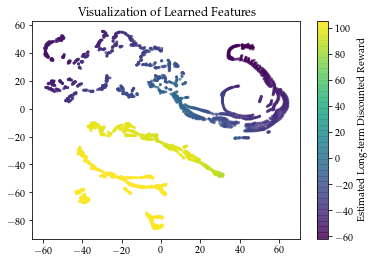

In [300]:
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=color_vals, alpha=0.6, s=4)
cb = plt.colorbar(scatter)
cb.set_label('Estimated Long-term Discounted Reward')
plt.title('Visualization of Learned Features')

plt.savefig('../figs/tsne.png')

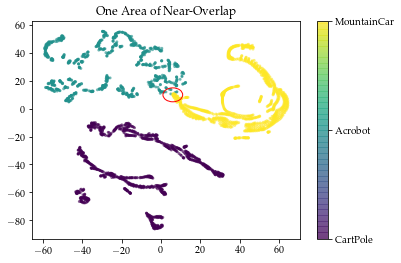

In [329]:
x = 6
y = 10
radius= 5

which_env = np.zeros(3000)
which_env[1000:2000] = 1
which_env[2000:] = 2

fig, ax = plt.subplots()
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=which_env, alpha=0.5, s=4)
c = plt.Circle((x, y), radius, fill=False, color='red')
ax.add_artist(c)
cbar = fig.colorbar(scatter, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['CartPole', 'Acrobot', 'MountainCar'])

plt.title('One Area of Near-Overlap')
plt.savefig('../figs/overlap.png')

In [335]:
def show_point(idx, this_embedding, env_idx, filt, save=False, fname=None):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.scatter(embedding[:, 0], embedding[:, 1], c=color_vals, alpha=0.2, s=4)
    pt = this_embedding[filt][idx]
    ax1.plot(pt[0], pt[1], 'ro')
    
    c = plt.Circle((x, y), radius, fill=False, color='red')
    ax1.add_artist(c)

    
    env = envs[env_idx].unwrapped
    s = held_states[env_idx][filt][idx]
    env.state = s
    img = env.render(mode='rgb_array')
    ax2.imshow(img)
    value = torch.max(agts[env_idx].Q(s)).detach().numpy()
    ax2.text(300, 50, '$\hat{V} = ' + str(value) + '$', fontsize=12)
    
    plt.suptitle('Single State')

    env.close()
    
    if save:
        plt.savefig(f'../figs/{fname}')
    else:
        plt.show()

    
filt_acro = np.logical_and(
    np.logical_and(
        embedding[1000:2000, 0] > x - radius,
        embedding[1000:2000, 0] < x + radius
    ),
    np.logical_and(
        embedding[1000:2000, 1] > y - radius,
        embedding[1000:2000, 1] < y + radius
    )
)

filt_mc = np.logical_and(
    np.logical_and(
        embedding[2000:, 0] > x - radius,
        embedding[2000:, 0] < x + radius
    ),
    np.logical_and(
        embedding[2000:, 1] > y - radius,
        embedding[2000:, 1] < y + radius
    )
)

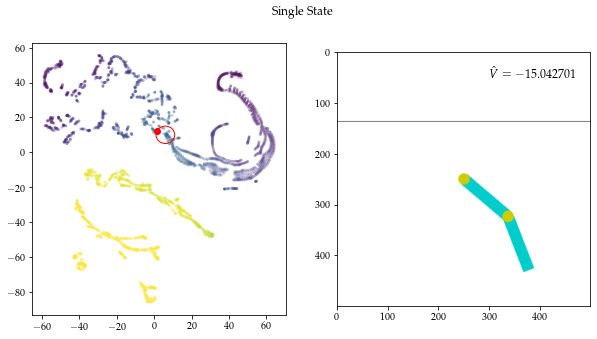

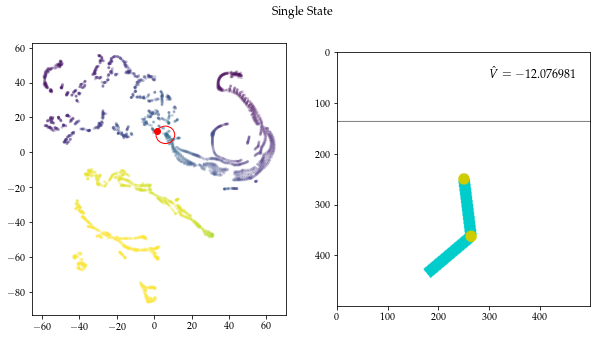

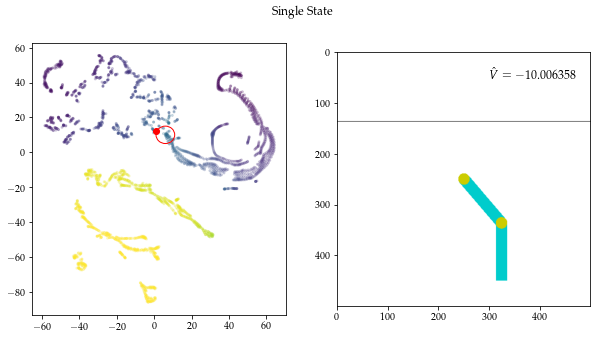

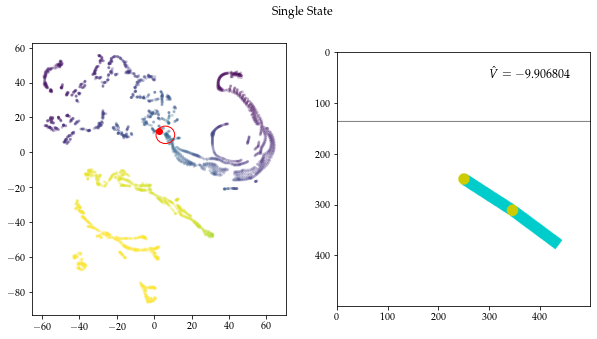

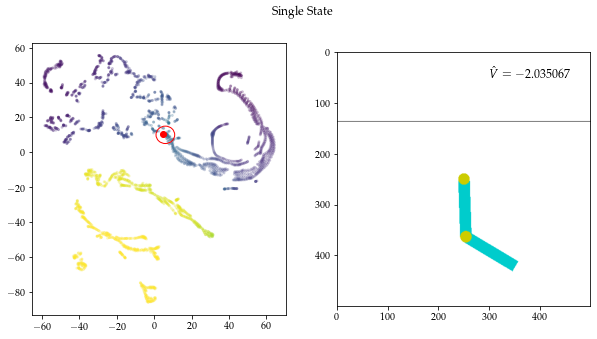

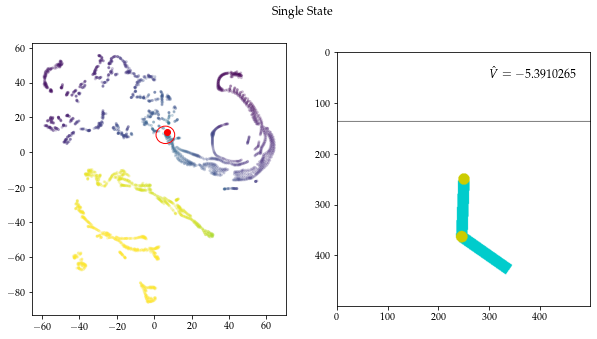

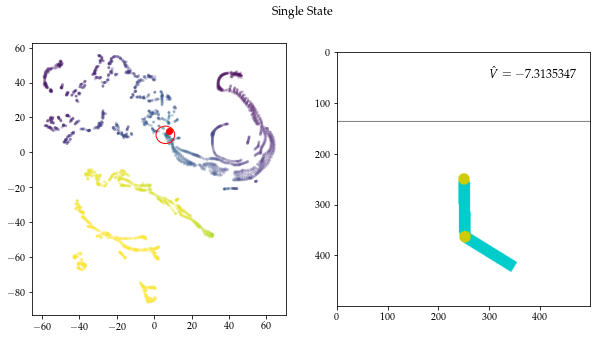

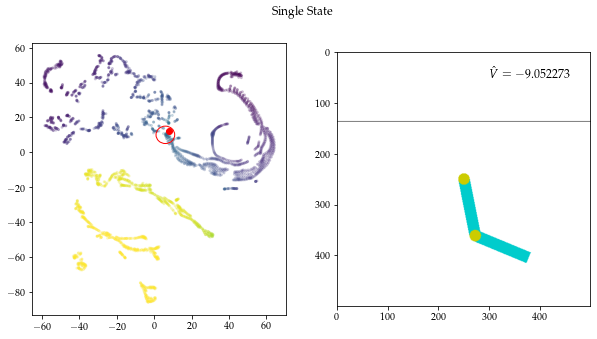

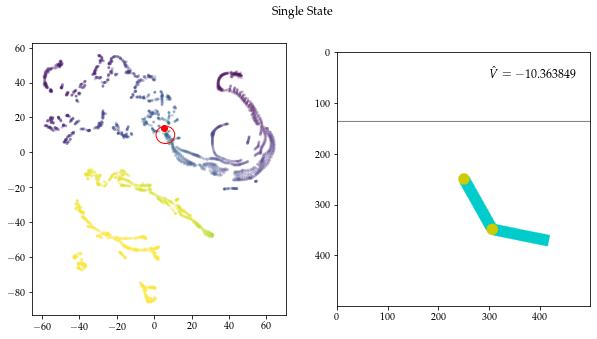

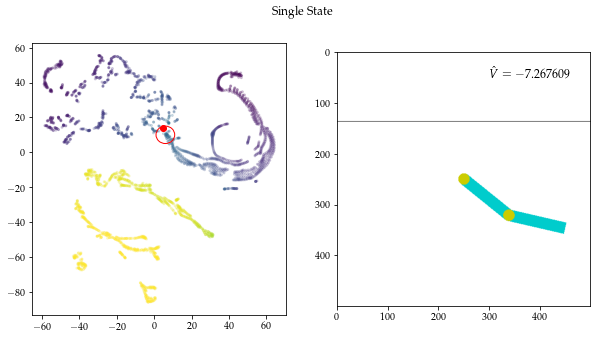

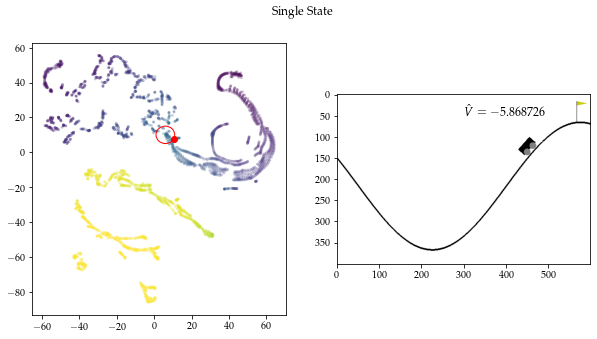

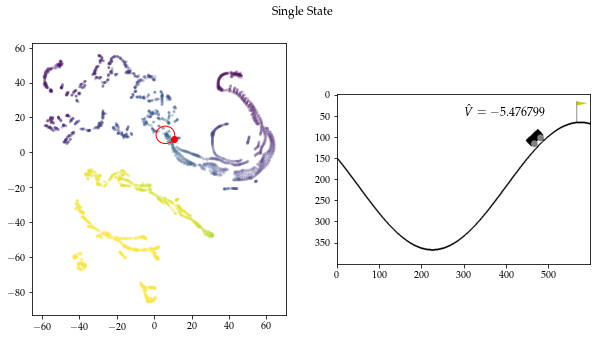

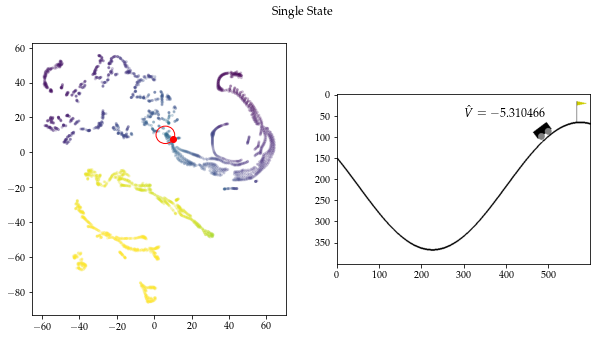

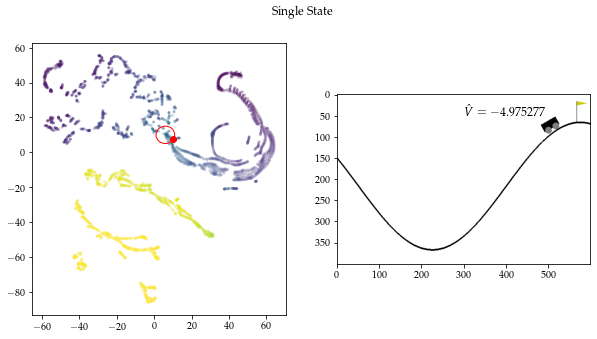

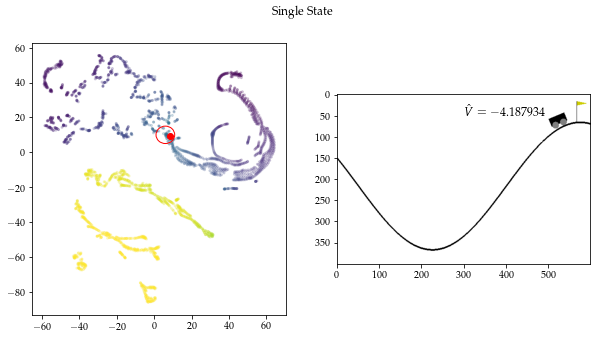

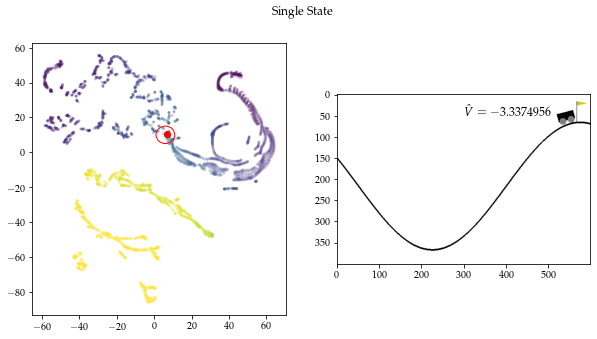

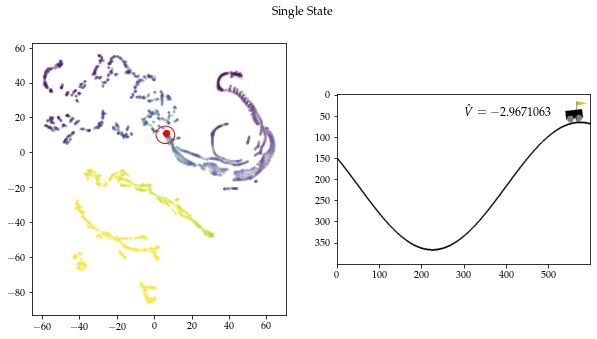

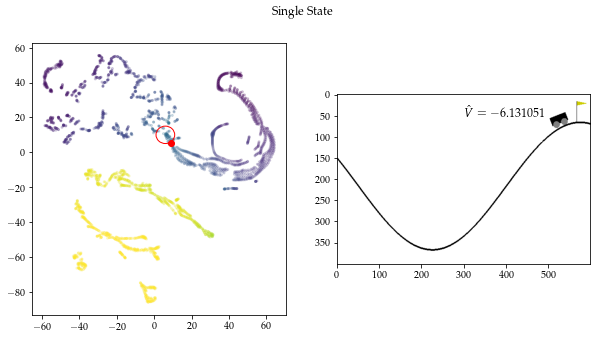

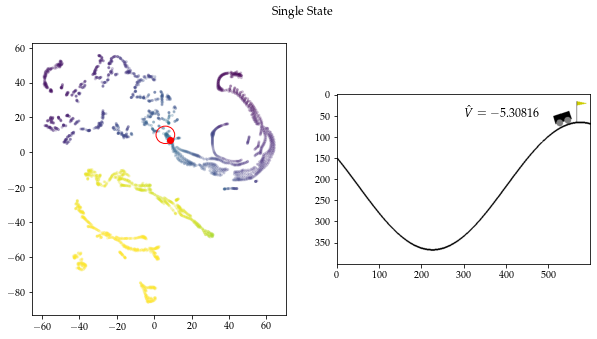

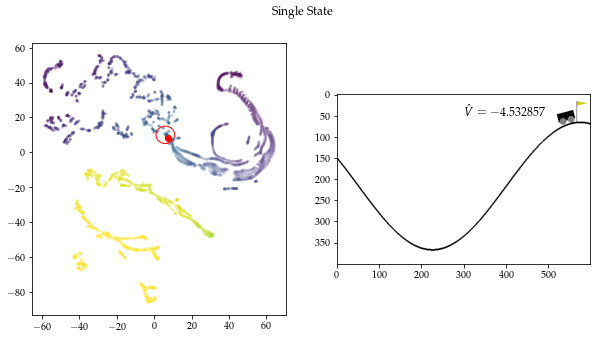

In [337]:
for emb, idx, filt, name in zip(
    [embedding[1000:2000], embedding[2000:]],
    [1, 2],
    [filt_acro, filt_mc],
    ['acro', 'mc']
):
    for n in range(10):
        show_point(n, emb, idx, filt, save=True, fname=f'vis_{name}_{n}.png')